In [ ]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader, random_split  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from sklearn.metrics import confusion_matrix
import timeit
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### Loading training and testing dataset

In [ ]:
# Load Training and Test data
batch_size = 64
train_dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_dataset, valid_dataset = random_split(train_dataset,[40000,10000])

test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


### Setting device to GPU to speed up

In [ ]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)


'Tesla T4'

#### Hyperparameters of our network which depends on the dataset

In [ ]:

in_channels = 3
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 5

### 2 Layer CNN model with batch normalization

In [ ]:
class Cifar10CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2), # output: 8 x 16 x 16

            nn.Conv2d(8, 24, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.MaxPool2d(2, 2), # output: 24 x 8 x 8

            nn.Flatten(), 
            nn.Linear(24*8*8, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
            )
        
    def forward(self, x):
        return self.network(x)

### 2 Layer CNN model without batch normalization

In [ ]:
class Cifar10CnnModel_no_batch_norm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2), # output: 8 x 16 x 16

            nn.Conv2d(8, 24, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(24),
            nn.MaxPool2d(2, 2), # output: 24 x 8 x 8

            nn.Flatten(), 
            nn.Linear(24*8*8, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
            )
        
    def forward(self, x):
        return self.network(x)

### 3 Layer CNN model with batch normalization

In [ ]:
class Cifar10CnnModel_3_layers(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(5),
            nn.MaxPool2d(2, 2), # output: 5 x 16 x 16

            nn.Conv2d(5, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(2, 2), # output: 10 x 8 x 8

            nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.MaxPool2d(2, 2), # output: 20 x 4 x 4

            nn.Flatten(), 
            nn.Linear(20*4*4, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
            )
        
    def forward(self, x):
        return self.network(x)

#### Reseting parameters of model

In [ ]:
def reset_network_params(model):
  for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
  return model

In [ ]:

# Hyperparameters of our neural network which depends on the dataset, and
# also just experimenting to see what works well (learning rate for example).
in_channels = 3
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 10


#### Function to plot Train loss and validation loss per epoch

In [ ]:
def plot_losses(train_loss, valid_loss):
  plt.plot(train_loss, '-bx')
  plt.plot(valid_loss, '-rx')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(['Training', 'Validation'])
  plt.title("Loss vs Epoch")

#### Funtion to plot accuracy per epoch during training

In [ ]:
def plot_accuracy(accuracy, num_epoch=30):
  #plt.plot(train_loss, '-bx')
  plt.plot(accuracy, '-ro')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  #plt.legend(['Training', 'Validation'])
  plt.title("Accuracy vs Epoch")

#### Funtion to calculate accuracy of model

In [ ]:

# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    pred = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct/num_samples



#### Funtion to show confusion matrix

(10000,) (10000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> [2. 1. 3. ... 2. 6. 5.]


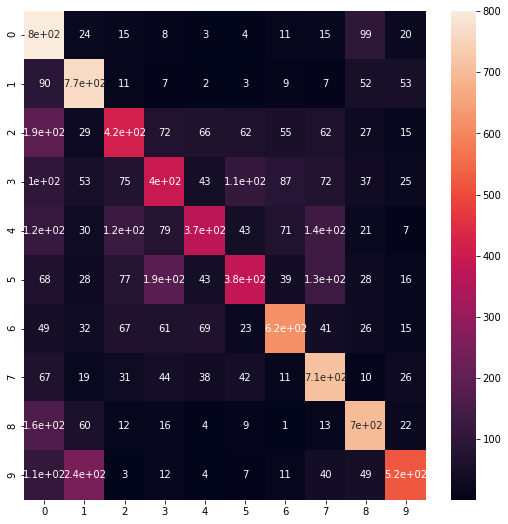

In [ ]:
import seaborn as sns
# Check accuracy on training & test to see how good our model
def get_confusion_matrix(loader, model):
    with torch.no_grad():
        pred = np.zeros(1)
        actual = np.zeros(1)
        for x, y in loader:
            actual = np.append(actual, y.numpy())
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            #print(predictions)
            pred = np.append(pred, predictions.cpu().data.numpy())
            #print(i,predictions.shape)
            #i+=1
            #break
    actual = actual[1:]
    pred = pred[1:]
    print(actual.shape, pred.shape)
    print(type(actual), type(pred),pred)
    actual = actual.astype(int)
    pred = pred.astype(int)
    #return actual, pred
    cf_mat = confusion_matrix(list(actual), list(pred) )
    plt.figure(figsize=(9,9))
    sns.heatmap(cf_mat, annot=True)
    #return cf_mat



#### Training with validation

In [ ]:

def train_model(model, criterion, optimizer, num_epoch=5):
  start = timeit.default_timer()
  accuracy = []
  train_loss = []
  valid_loss = []
  # Train Network
  for epoch in range(num_epoch):
      tr_loss = 0.0
      for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
          # Get data to cuda if possible
          data = data.to(device=device)
          targets = targets.to(device=device)

          # forward
          scores = model(data)
          loss = criterion(scores, targets)

          # backward
          optimizer.zero_grad()
          loss.backward()

          # gradient descent or adam step
          optimizer.step()
          tr_loss += loss.item()
      #if (epoch==num_epochs-1):
      #  checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
      #  save_checkpoint(checkpoint)
      Loss = tr_loss / len(train_loader)
      train_loss.append(Loss) 
      
      #---------  VALIDATION STEP------------------------------------
      val_loss = 0.0
      model.eval()     # Optional when not using Model Specific layer
      for data, labels in valid_loader:
          if torch.cuda.is_available():
              data, labels = data.cuda(), labels.cuda()
          
          target = model(data)
          loss = criterion(target,labels)
          val_loss += loss.item() #* data.size(0)
      val_loss /= len(valid_loader) 
      valid_loss. append(val_loss)
      #--------------------------------------------------------------

      #------------- Accuracy at this epoch -------------------------
      acc = check_accuracy(test_loader, model)*100
      accuracy.append(acc)
      #--------------------------------------------------------------
      print("\nEpoch : ",epoch,"  Train Loss : ",Loss,"  Validation Loss : ",val_loss,"  Accuracy : ",acc,"\n")
  stop = timeit.default_timer()

  print('Time: ', stop - start)  
  return train_loss, valid_loss, accuracy


### Model with 2 layers

In [ ]:
# Model # 2 layers
model1 = Cifar10CnnModel()
#print(model)
model1.to(device)
reset_network_params(model1)
# Loss and optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.045, momentum=0.4)
train_loss, valid_loss, accuracy = train_model(model1, criterion1, optimizer1, num_epoch=30)
print(f"Accuracy on training set: {check_accuracy(train_loader, model1)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model1)*100:.2f}")


  2%|▏         | 12/625 [00:00<00:05, 110.19it/s]


Epoch :  0   Train Loss :  2.075487723350525   Validation Loss :  2.019651779703274   Accuracy :  tensor(45.0300, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 116.24it/s]


Epoch :  1   Train Loss :  1.9689283845901489   Validation Loss :  2.0210366704661373   Accuracy :  tensor(43.6300, device='cuda:0') 



  2%|▏         | 10/625 [00:00<00:06, 95.59it/s]


Epoch :  2   Train Loss :  1.9337390436172486   Validation Loss :  2.013316067920369   Accuracy :  tensor(44.6800, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 116.39it/s]


Epoch :  3   Train Loss :  1.9134241981506348   Validation Loss :  1.9631779095169846   Accuracy :  tensor(49.8200, device='cuda:0') 



  2%|▏         | 10/625 [00:00<00:06, 96.90it/s]


Epoch :  4   Train Loss :  1.8969952732086182   Validation Loss :  1.944304291609746   Accuracy :  tensor(52.1900, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 116.32it/s]


Epoch :  5   Train Loss :  1.8853394498825073   Validation Loss :  1.9325193189511634   Accuracy :  tensor(53.8000, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 119.62it/s]


Epoch :  6   Train Loss :  1.874745804786682   Validation Loss :  1.9313136407524158   Accuracy :  tensor(53.3800, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:05, 121.13it/s]


Epoch :  7   Train Loss :  1.8644957111358642   Validation Loss :  1.9447958811073547   Accuracy :  tensor(52.2500, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 118.80it/s]


Epoch :  8   Train Loss :  1.8550237424850464   Validation Loss :  1.9259904592659822   Accuracy :  tensor(54.0800, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 112.97it/s]


Epoch :  9   Train Loss :  1.84506166305542   Validation Loss :  1.913989196157759   Accuracy :  tensor(55.5400, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 119.29it/s]


Epoch :  10   Train Loss :  1.8348705959320069   Validation Loss :  1.90267293240614   Accuracy :  tensor(56.2700, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 117.06it/s]


Epoch :  11   Train Loss :  1.8288408834457397   Validation Loss :  1.9727894865023863   Accuracy :  tensor(48.6400, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 117.83it/s]


Epoch :  12   Train Loss :  1.8210516929626466   Validation Loss :  1.9052968420040834   Accuracy :  tensor(56.0900, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 118.65it/s]


Epoch :  13   Train Loss :  1.813783546257019   Validation Loss :  1.9118629709170882   Accuracy :  tensor(54.8700, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 118.11it/s]


Epoch :  14   Train Loss :  1.803927071762085   Validation Loss :  1.9066634960235305   Accuracy :  tensor(56.0900, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 116.19it/s]


Epoch :  15   Train Loss :  1.799175588607788   Validation Loss :  1.910062912922756   Accuracy :  tensor(55.5000, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 118.53it/s]


Epoch :  16   Train Loss :  1.7935175003051758   Validation Loss :  1.8989375427270392   Accuracy :  tensor(56.5700, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 117.47it/s]


Epoch :  17   Train Loss :  1.787188676071167   Validation Loss :  1.9105558797812006   Accuracy :  tensor(55.6300, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 118.49it/s]


Epoch :  18   Train Loss :  1.782317685699463   Validation Loss :  1.8981479702481798   Accuracy :  tensor(56.9000, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 113.83it/s]


Epoch :  19   Train Loss :  1.7774142736434937   Validation Loss :  1.9001982925803798   Accuracy :  tensor(56.4700, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 115.23it/s]


Epoch :  20   Train Loss :  1.7732947593688966   Validation Loss :  1.8957941995304861   Accuracy :  tensor(56.7800, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 117.64it/s]


Epoch :  21   Train Loss :  1.7695393392562866   Validation Loss :  1.8975632987963926   Accuracy :  tensor(56.7500, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 114.01it/s]


Epoch :  22   Train Loss :  1.7653420579910277   Validation Loss :  1.8984550169319103   Accuracy :  tensor(56.7500, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 108.79it/s]


Epoch :  23   Train Loss :  1.7615287612915038   Validation Loss :  1.8995602290341809   Accuracy :  tensor(56.7400, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 115.95it/s]


Epoch :  24   Train Loss :  1.7580052244186402   Validation Loss :  1.9016222460254741   Accuracy :  tensor(57.0900, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 118.13it/s]


Epoch :  25   Train Loss :  1.7541300918579101   Validation Loss :  1.8982190698575063   Accuracy :  tensor(56.3400, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 115.67it/s]


Epoch :  26   Train Loss :  1.7519637481689454   Validation Loss :  1.8954928490766294   Accuracy :  tensor(57.0100, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 104.60it/s]


Epoch :  27   Train Loss :  1.7494395906448363   Validation Loss :  1.8975928748489186   Accuracy :  tensor(56.9000, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 113.41it/s]


Epoch :  28   Train Loss :  1.7477424934387207   Validation Loss :  1.8959152698516846   Accuracy :  tensor(56.8900, device='cuda:0') 



100%|██████████| 625/625 [00:05<00:00, 117.88it/s]



Epoch :  29   Train Loss :  1.7453002153396606   Validation Loss :  1.896223933074125   Accuracy :  tensor(56.8800, device='cuda:0') 

Time:  219.2611160209999
Accuracy on training set: 71.94
Accuracy on test set: 56.88


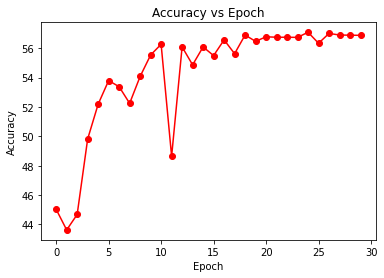

In [ ]:
plot_accuracy(accuracy, num_epoch=30)

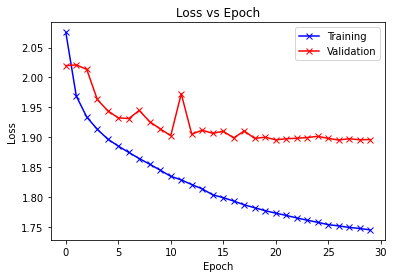

In [ ]:
plot_losses(train_loss, valid_loss) 


#### Model with 3 layers

In [ ]:

# Model # 3 layers
model_3 = Cifar10CnnModel_3_layers()
#print(model_3)
model_3.to(device)
#reset_network_params(model_3_layers)
# Loss and optimizer
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001)
train_loss, valid_loss, accuracy = train_model(model_3, criterion_3, optimizer_3, num_epoch=20)
print(f"Accuracy on training set: {check_accuracy(train_loader, model_3)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model_3)*100:.2f}")
#plot_losses(train_loss, valid_loss) 
#plot_accuracy(accuracy, num_epoch=10)

  2%|▏         | 11/625 [00:00<00:05, 103.00it/s]


Epoch :  0   Train Loss :  2.0523851663589476   Validation Loss :  2.0031144019145115   Accuracy :  tensor(46.1200, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:06, 99.42it/s]


Epoch :  1   Train Loss :  1.9298177127838134   Validation Loss :  1.945282867759656   Accuracy :  tensor(51.6900, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 106.58it/s]


Epoch :  2   Train Loss :  1.8888090454101563   Validation Loss :  1.9043856570675115   Accuracy :  tensor(55.3300, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 106.72it/s]


Epoch :  3   Train Loss :  1.8639403297424317   Validation Loss :  1.8878656192949623   Accuracy :  tensor(56.6600, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 107.95it/s]


Epoch :  4   Train Loss :  1.8495593692779542   Validation Loss :  1.8815721455653003   Accuracy :  tensor(57.6400, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 106.53it/s]


Epoch :  5   Train Loss :  1.836829768562317   Validation Loss :  1.9126983190038402   Accuracy :  tensor(54.2700, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 106.35it/s]


Epoch :  6   Train Loss :  1.8266506002426148   Validation Loss :  1.8817089591056677   Accuracy :  tensor(57.6300, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 108.20it/s]


Epoch :  7   Train Loss :  1.8142312362670898   Validation Loss :  1.8428786142616516   Accuracy :  tensor(61.2400, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 107.75it/s]


Epoch :  8   Train Loss :  1.807448045539856   Validation Loss :  1.857180212713351   Accuracy :  tensor(60.4600, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 104.82it/s]


Epoch :  9   Train Loss :  1.79887044506073   Validation Loss :  1.8671202568491554   Accuracy :  tensor(59.5000, device='cuda:0') 



  2%|▏         | 10/625 [00:00<00:06, 96.81it/s]


Epoch :  10   Train Loss :  1.7907385690689086   Validation Loss :  1.8374663454711817   Accuracy :  tensor(62.0500, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 104.09it/s]


Epoch :  11   Train Loss :  1.783159854888916   Validation Loss :  1.8324605142994292   Accuracy :  tensor(62.5200, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 106.83it/s]


Epoch :  12   Train Loss :  1.7792068752288819   Validation Loss :  1.8361903072162797   Accuracy :  tensor(61.7300, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 107.42it/s]


Epoch :  13   Train Loss :  1.771619983291626   Validation Loss :  1.8337597907728451   Accuracy :  tensor(61.5900, device='cuda:0') 



  2%|▏         | 10/625 [00:00<00:06, 99.26it/s]


Epoch :  14   Train Loss :  1.7683778451919556   Validation Loss :  1.8423797362928938   Accuracy :  tensor(61.4500, device='cuda:0') 



  2%|▏         | 10/625 [00:00<00:06, 93.91it/s]


Epoch :  15   Train Loss :  1.7618861293792725   Validation Loss :  1.8354177748321727   Accuracy :  tensor(62.6700, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:06, 99.95it/s]


Epoch :  16   Train Loss :  1.75730876121521   Validation Loss :  1.8481408182982426   Accuracy :  tensor(60.8300, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 107.69it/s]


Epoch :  17   Train Loss :  1.7520442029953003   Validation Loss :  1.823456330663839   Accuracy :  tensor(63.5000, device='cuda:0') 



  2%|▏         | 10/625 [00:00<00:06, 99.60it/s]


Epoch :  18   Train Loss :  1.7482435693740845   Validation Loss :  1.8400587443333523   Accuracy :  tensor(62.2000, device='cuda:0') 



100%|██████████| 625/625 [00:05<00:00, 106.27it/s]



Epoch :  19   Train Loss :  1.745889712715149   Validation Loss :  1.8561766777828241   Accuracy :  tensor(60.3600, device='cuda:0') 

Time:  159.02383064599962
Accuracy on training set: 67.63
Accuracy on test set: 60.36


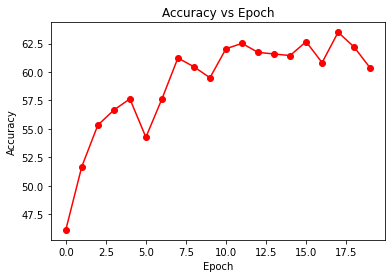

In [ ]:
plot_accuracy(accuracy, num_epoch=20)

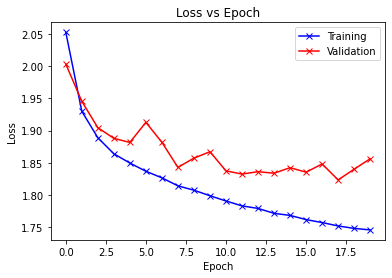

In [ ]:
plot_losses(train_loss, valid_loss) 


Accuracy on training set: 85.78
Accuracy on test set: 64.01


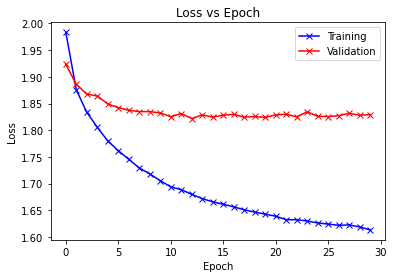

In [ ]:

print(f"Accuracy on training set: {check_accuracy(train_loader, model3)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model3)*100:.2f}")
plot_losses(train_loss, valid_loss)

#### without batch normalization

In [ ]:

# Model # 3 layers
model_no_norm = Cifar10CnnModel_no_batch_norm()
#print(model_3)
model_no_norm.to(device)
#reset_network_params(model_3_layers)
# Loss and optimizer
criterion_no_norm = nn.CrossEntropyLoss()
optimizer_no_norm = optim.SGD(model_no_norm.parameters(), lr=0.023, momentum=0.9)

train_loss, valid_loss, accuracy = train_model(model_no_norm, criterion_no_norm, optimizer_no_norm, num_epoch=20)
print(f"Accuracy on training set: {check_accuracy(train_loader, model_no_norm)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model_no_norm)*100:.2f}")
#plot_losses(train_loss, valid_loss) 
#plot_accuracy(accuracy, num_epoch=10)

  2%|▏         | 13/625 [00:00<00:04, 124.51it/s]


Epoch :  0   Train Loss :  2.2722289394378663   Validation Loss :  2.23170355171155   Accuracy :  tensor(21.6300, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 124.36it/s]


Epoch :  1   Train Loss :  2.1848716552734375   Validation Loss :  2.1516956516132235   Accuracy :  tensor(31.4100, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 125.53it/s]


Epoch :  2   Train Loss :  2.1181235244750978   Validation Loss :  2.0913735332003065   Accuracy :  tensor(37.5100, device='cuda:0') 



  2%|▏         | 12/625 [00:00<00:05, 119.73it/s]


Epoch :  3   Train Loss :  2.055847933769226   Validation Loss :  2.028147952571796   Accuracy :  tensor(43.5900, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 124.49it/s]


Epoch :  4   Train Loss :  2.014722950553894   Validation Loss :  2.002693239291003   Accuracy :  tensor(46.2100, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:05, 120.93it/s]


Epoch :  5   Train Loss :  1.9892866199493409   Validation Loss :  1.9898035518682686   Accuracy :  tensor(47.5800, device='cuda:0') 



  2%|▏         | 11/625 [00:00<00:05, 106.45it/s]


Epoch :  6   Train Loss :  1.967817041015625   Validation Loss :  2.0161142842784807   Accuracy :  tensor(44.5700, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 123.93it/s]


Epoch :  7   Train Loss :  1.9543169597625731   Validation Loss :  1.9560126825502724   Accuracy :  tensor(51.2900, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:05, 121.30it/s]


Epoch :  8   Train Loss :  1.9396621633529663   Validation Loss :  1.9464656638491684   Accuracy :  tensor(51.5800, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 125.61it/s]


Epoch :  9   Train Loss :  1.9225964830398559   Validation Loss :  1.9336781805487955   Accuracy :  tensor(53.2600, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 124.82it/s]


Epoch :  10   Train Loss :  1.9122577512741088   Validation Loss :  1.9310720748962111   Accuracy :  tensor(52.5100, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 122.84it/s]


Epoch :  11   Train Loss :  1.8926685346603394   Validation Loss :  1.910486730041018   Accuracy :  tensor(54.7900, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 123.23it/s]


Epoch :  12   Train Loss :  1.8855200798034668   Validation Loss :  1.8996189513783546   Accuracy :  tensor(55.8600, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 124.59it/s]


Epoch :  13   Train Loss :  1.8756328550338746   Validation Loss :  1.9094208258732108   Accuracy :  tensor(54.9600, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 125.09it/s]


Epoch :  14   Train Loss :  1.8653769628524781   Validation Loss :  1.9186678411095006   Accuracy :  tensor(53.6800, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 122.57it/s]


Epoch :  15   Train Loss :  1.8542300926208497   Validation Loss :  1.8984798276500336   Accuracy :  tensor(56.2700, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 122.63it/s]


Epoch :  16   Train Loss :  1.852666702079773   Validation Loss :  1.891236643882314   Accuracy :  tensor(56.3600, device='cuda:0') 



  2%|▏         | 13/625 [00:00<00:04, 123.11it/s]


Epoch :  17   Train Loss :  1.84364409866333   Validation Loss :  1.8941791163887947   Accuracy :  tensor(56.4800, device='cuda:0') 



  2%|▏         | 10/625 [00:00<00:06, 95.40it/s]


Epoch :  18   Train Loss :  1.8426315635681152   Validation Loss :  1.9100979900663826   Accuracy :  tensor(54.8500, device='cuda:0') 



100%|██████████| 625/625 [00:05<00:00, 120.31it/s]



Epoch :  19   Train Loss :  1.8368629146575928   Validation Loss :  1.890590553071089   Accuracy :  tensor(56.8500, device='cuda:0') 

Time:  142.05573379700036
Accuracy on training set: 62.17
Accuracy on test set: 56.85


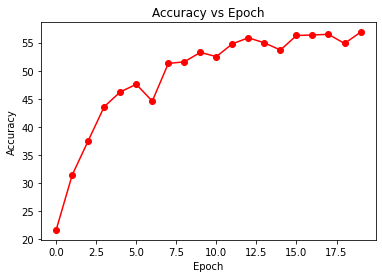

In [ ]:
plot_accuracy(accuracy, num_epoch=20)

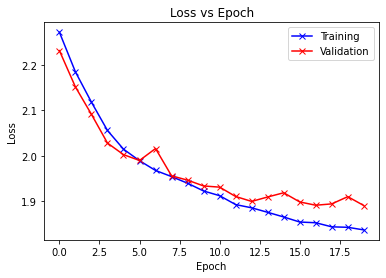

In [ ]:
plot_losses(train_loss, valid_loss) 
